# Evasion Attacks - Part 1



### References
ART Example TODO https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/get_started_pytorch.py

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt 


In [2]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

In [3]:

# Step 0: Define the neural network model, return logits instead of activation in forward method


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

### MNIST Dataset 

In [4]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)


### Define the Model 

In [5]:
model = Net()

# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


### ART Classifier
Familiarize with the classifier concept in ART.

It is basically a wrapper around our model

In [6]:
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)


### Evaluation
- benign examples
- adversarial examples

#### Benign examples

In [7]:
# Determine accuracy of the model on test set (benign examples)
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))



Accuracy on benign test examples: 97.89%


#### Create adversarial examples with the Fast Gradient Method


In [8]:
# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

adv_predictions = classifier.predict(x_test_adv)
adv_accuracy = np.sum(np.argmax(adv_predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(adv_accuracy * 100))

Accuracy on adversarial test examples: 42.77%


## Evaluation
- Adveresarial examples: Plot the confusion matrix
- Plot example pictures for right and wrong classification 
- Visualize the difference between exemplary benign images and the corresponding adversarials
- Where do you find the attack parameter $\epsilon$ in your adversarial images? 

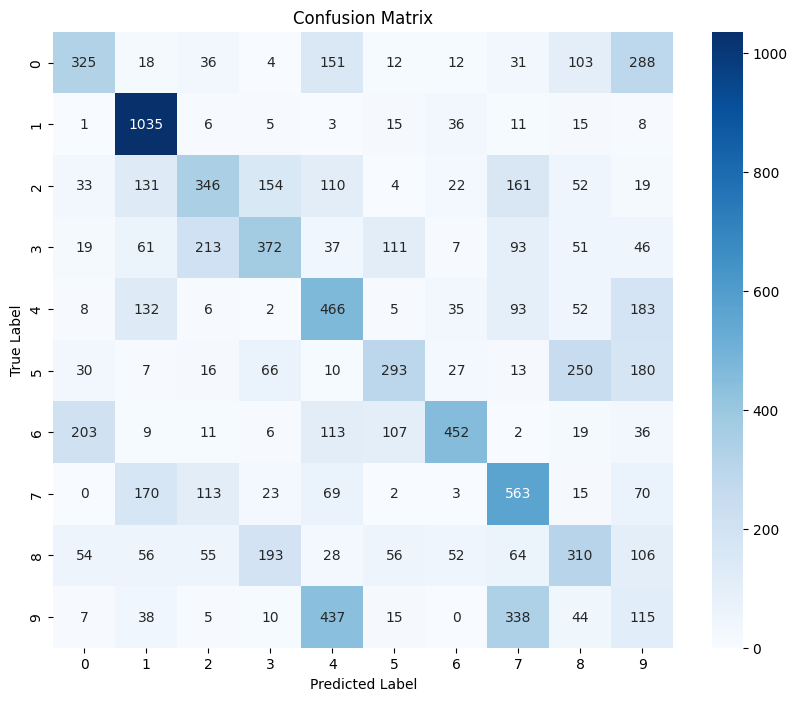

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(adv_predictions, axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


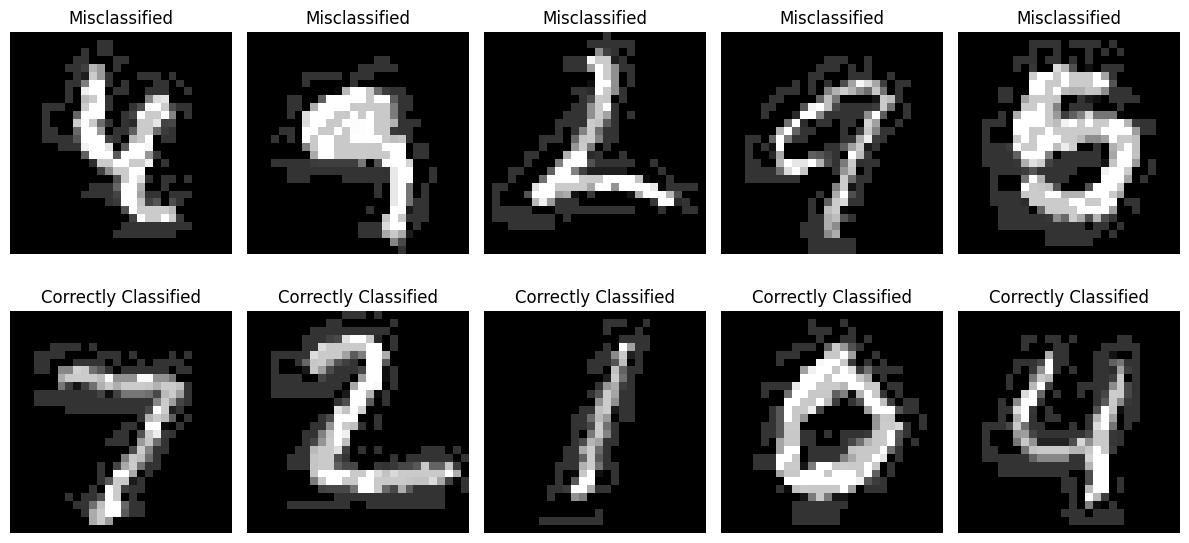

In [13]:
# Find indices of correctly classified examples
correctly_classified_indices = np.where(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))[0]
misclassified_indices = np.where(np.argmax(predictions, axis=1) != np.argmax(y_test, axis=1))[0]

# Choose multiple misclassified and correctly classified examples
num_examples = 5
misclassified_examples = x_test_adv[misclassified_indices[:num_examples]]
correctly_classified_examples = x_test_adv[correctly_classified_indices[:num_examples]]

# Plot misclassified examples
plt.figure(figsize=(12, 6))
for i in range(num_examples):
    plt.subplot(2, num_examples, i + 1)
    plt.imshow(misclassified_examples[i].reshape(28, 28), cmap='gray')
    plt.title('Misclassified')
    plt.axis('off')

# Plot correctly classified examples
for i in range(num_examples):
    plt.subplot(2, num_examples, num_examples + i + 1)
    plt.imshow(correctly_classified_examples[i].reshape(28, 28), cmap='gray')
    plt.title('Correctly Classified')
    plt.axis('off')

plt.tight_layout()
plt.show()


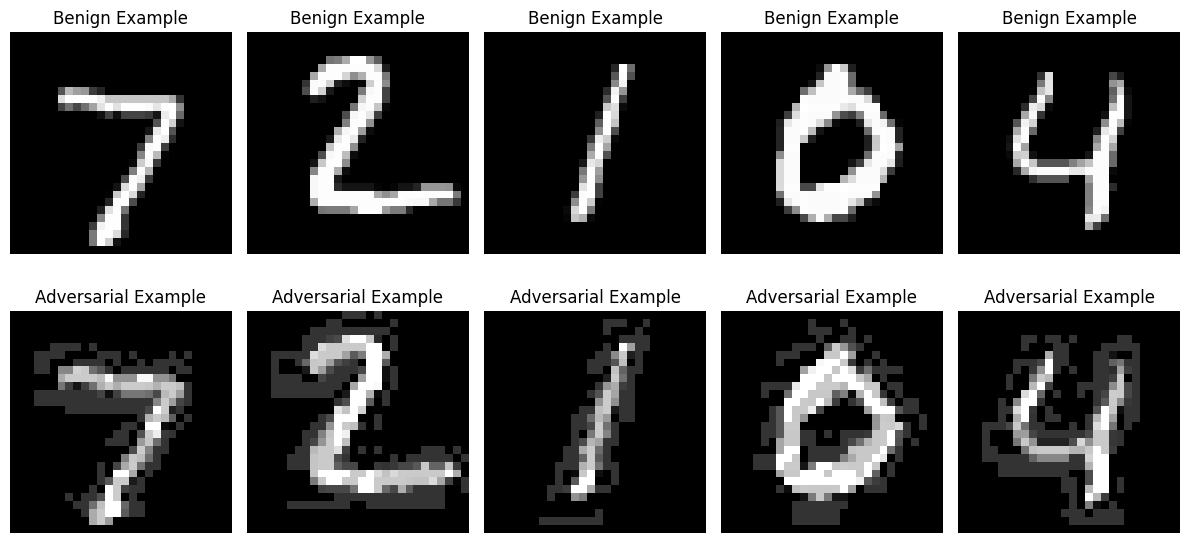

In [14]:
# Choose multiple exemplary benign images and their corresponding adversarial examples
benign_examples = x_test[:num_examples]
adversarial_examples = x_test_adv[:num_examples]

# Plot exemplary benign images and their adversarial examples
plt.figure(figsize=(12, 6))
for i in range(num_examples):
    # Plot benign example
    plt.subplot(2, num_examples, i + 1)
    plt.imshow(benign_examples[i].reshape(28, 28), cmap='gray')
    plt.title('Benign Example')
    plt.axis('off')

    # Plot adversarial example
    plt.subplot(2, num_examples, num_examples + i + 1)
    plt.imshow(adversarial_examples[i].reshape(28, 28), cmap='gray')
    plt.title('Adversarial Example')
    plt.axis('off')

plt.tight_layout()
plt.show()
